# Prediction+RenderQueue
In diesem Notebook wird mit den erzeugten Modellen gearbeitet und entweder einzelne bilder oder ganze Queues Bearbeitet!


# Predict Images Setup

In [1]:
#Imports
import os
import cv2
import numpy as np
from numpy.random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras import Model
from keras.models import load_model
import keras.backend as K

## Configuration

In [2]:
#Model Config
#modelname='Model_atEpoch_2'
modelname='First Model Long Training\\gen_e_Fin'

#Single IMG Prediction Config
LR_IMGPATH="ULR_Pic\\ULR_00000.png"
HR_IMGPATH = "HR_Pic\\HR_00000.png"


#Render Queue Config
INPUT = "Input\\"
PREDICTION = "Prediction\\"


## Load Model

In [3]:
generator = load_model(str(modelname+'.h5'), compile=False)

## Initialise Model with right shape

In [4]:

hr_image =cv2.imread(HR_IMGPATH,flags= cv2.IMREAD_COLOR)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

def extract_pixel_sample(image, x, y, size=128):
    sample = image[y:y+size, x:x+size]
    return sample
initializesample =[]

initializesample.append(extract_pixel_sample(hr_image,0,0,size=32))
initializesample = np.array(initializesample)
initializesample = initializesample/255.0
initializesample = np.reshape(initializesample,(-1,32,32,3))

initprediction = generator.predict(initializesample)

1/1 [==============================] - 1s 1s/step


## Define Score Functions

In [15]:
# PSNR Function and !SSIM Function!
from skimage.metrics import structural_similarity


def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    (score, diff) = structural_similarity(y_true, y_pred, full=True,channel_axis=2,data_range=1)
    diff = (diff * 255).astype("uint8")
    return str("SSIM: "+str(score))

# Predict Single Image

1/1 [==============================] - 17s 17s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


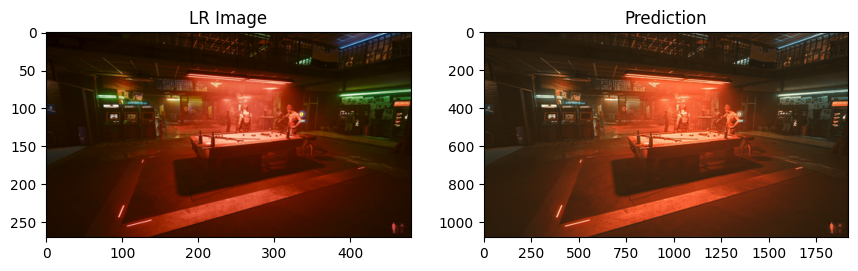

SSIM: 0.5941318346952231
PSNR:  23.887145446945794


In [16]:
lr_image = cv2.imread(LR_IMGPATH,flags= cv2.IMREAD_COLOR)
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
hr_image =cv2.imread(HR_IMGPATH,flags= cv2.IMREAD_COLOR)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

lr_image = lr_image / 255.0
hr_image = hr_image / 255.0

lr_image = np.expand_dims(lr_image, axis=0)
generated_sreeni_hr = generator.predict(lr_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lr_image[0,:,:,:])
plt.subplot(232)
plt.title('Prediction')
plt.imshow(generated_sreeni_hr[0,:,:,:])

#save plot for Comparison
plt.savefig(str(modelname+".jpg"),bbox_inches ='tight')
plt.show()


#SSIM
print(SSIM(hr_image ,np.squeeze(generated_sreeni_hr,axis=0)))


#PSNR
psnr = PSNR(hr_image,generated_sreeni_hr)
print("PSNR: ",np.mean(psnr))



# Render Queue

In [ ]:
def predict_X(input_datei, output_datei):

    lr = cv2.imread(input_datei,flags= cv2.IMREAD_COLOR)
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    lr = lr / 255.
    lr = np.expand_dims(lr, axis=0)

    generated__hr = generator.predict(lr)


    generated__hr[0,:,:,:] = cv2.imwrite(output_datei,cv2.cvtColor(generated__hr[0,:,:,:]*255,cv2.COLOR_RGB2BGR))


for img in tqdm(os.listdir(INPUT)):
    predict_X(str(INPUT+img) , str(PREDICTION+"HR"+img[3:]))#Change nuber in [] for length of name till number or seperator. Example "ULR_0000" =>[3:] =>"_0000"

# SSIM/PSNR Durchschnitt für Ordner mit Bildern

In [25]:
# PSNR Function and !SSIM Function!
from skimage.metrics import structural_similarity

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    (score, diff) = structural_similarity(y_true, y_pred, full=True,channel_axis=2,data_range=1)
    diff = (diff * 255).astype("uint8")
    return score

In [30]:
#Bild dateien in beidem Ordnern sollten gleich heißen in diesem fall "HR_XXXX.png"
PREDICTIONIMG = "TestCapture\\Prediction"
NATIVEIMG ="TestCapture\\NativeIMG"

psnr_arr=[]
ssim_arr=[]


for img in tqdm(os.listdir(PREDICTIONIMG)):
    if img[-3:] == "png":

        #Prediction
        lr = cv2.imread(str(PREDICTIONIMG+"\\"+img),flags= cv2.IMREAD_COLOR)
        lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
        lr = lr / 255.
        lr = np.expand_dims(lr, axis=0)
        
        #Native
        hr = cv2.imread(str(NATIVEIMG+"\\"+img),flags= cv2.IMREAD_COLOR)
        hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
        hr = hr / 255.
        hr = np.expand_dims(hr, axis=0)
        
        lr = np.squeeze(lr,axis=0)
        hr = np.squeeze(hr,axis=0)
        
        psnr = PSNR(hr,lr)
        psnr_arr.append(np.mean(psnr))

        ssim_arr.append(SSIM(hr,lr))

print("PSNR: ",np.mean(np.array(psnr_arr)))
print("SSIM: ",np.mean(np.array(ssim_arr)))


output = "PSNR: "+ str(np.mean(np.array(psnr_arr)))
output = output+"\nSSIM: "+str(np.mean(np.array(ssim_arr)))
with open("PSNR_SSIM_TEST.txt","w") as f:
        f.write(str(output+"\n"))

print(output)



100%|██████████| 2227/2227 [55:31<00:00,  1.50s/it]

PSNR:  inf
SSIM:  0.695353341835415
PSNR: inf
SSIM: 0.695353341835415


In [32]:
print(psnr_arr)

[24.023535532147648, 24.02088112127565, 24.019881935335896, 24.02182758351799, 24.018915978008184, 24.018521656176816, 24.02092223463916, 24.018510289153262, 24.01851902666854, 24.020901825990244, 24.018510289153262, 24.0185299526083, 24.020902265771365, 24.01852014843624, 24.017458315159733, 24.019295300936996, 24.016558104796, 24.016159822488373, 24.01857892495955, 24.01576976043827, 24.01595911974039, 24.01785311759269, 24.015136788215134, 24.01507306472635, 24.017213939249785, 24.015070973972698, 24.014574774329756, 24.01697397988492, 24.013474561483566, 24.013312564436, 24.015473637112766, 24.012859859833426, 24.01360017140983, 24.015292659570235, 24.01272249105158, 24.011845674299725, 24.01420821423731, 24.01133759497256, 24.01101748947939, 24.013077286190324, 24.0107401822457, 24.01005731039309, 24.012022059946535, 24.01006773848982, 24.0097203146469, 24.011605053110525, 24.009015207367078, 24.008568835595124, 24.010247425141326, 24.007735265492304, 24.00808024607381, 24.0096421